In [1]:
%matplotlib inline

## Wavelength solution with RASCAL (v0.3.10)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from scipy.signal import find_peaks
from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

/opt/anaconda3/envs/Tiberius_env/lib/python3.8/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import peakutils
from scipy import stats,optimize,interpolate
import pickle
import reduction_utils.wavelength_calibration as wc

In [4]:
def rascal_find_wvl_solution(spectrum, wvl_min, wvl_max):
    peaks, _ = find_peaks(spectrum, prominence=150, distance=25, threshold=None)
    print(peaks)
    print(len(peaks))
    plt.figure()
    plt.plot(spectrum)
    plt.vlines(peaks,
              spectrum[peaks.astype('int')],
              spectrum.max(),
              colors='C1')
    
    peaks_refined=refine_peaks(spectrum, peaks, window_width=4)
    plt.figure()
    plt.plot(spectrum)
    plt.vlines(peaks_refined,0,1.05*spectrum.max(),colors='C1')
    
    # Set up the Calibrator object
    c = Calibrator(peaks_refined,
                   spectrum)
    c.set_calibrator_properties(num_pix=len(spectrum),
                                plotting_library='matplotlib',
                                log_level='info')
    
    c.plot_arc()

    c.set_hough_properties(
                       min_wavelength=wvl_min,
                       max_wavelength=wvl_max,
                       range_tolerance=500.,
                       linearity_tolerance=50)

    c.set_ransac_properties(sample_size=5,
                        top_n_candidate=8)
    
    c.add_atlas(elements=["He","Ar"])

    c.do_hough_transform()

    # Solve for the wavelength calibration
    best_polyfit_coefficient, match_peaks, match_atlas, rms, residual, peak_utilisation, atlas_utilisation = c.fit(max_tries=200,
                                                                  fit_deg=2, progress=True)

    print("RMS: {}".format(rms))
    print("Stdev error: {} A".format(np.abs(residual).std()))
    print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

    c.plot_fit(best_polyfit_coefficient)

    print(best_polyfit_coefficient)
    best_polyfit_coefficient = np.array(best_polyfit_coefficient)
    
    print(c.polyval(best_polyfit_coefficient,0))
    wvl = c.polyval(np.arange(0,row_max-row_min),best_polyfit_coefficient)
    return wvl

In [14]:
parent_direc = '/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-01-25/reduction_2/'

# Load in stellar spectra
s1 = pickle.load(open(parent_direc+'pickled_objects/star1_flux.pickle','rb'))
s2 = pickle.load(open(parent_direc+'pickled_objects/star2_flux.pickle','rb'))

# Load in x positions of traces, so that we can extract the arc spectra at the same locations as the stars
trace1 = pickle.load(open(parent_direc+'pickled_objects/x_positions_1.pickle','rb'))
trace2 = pickle.load(open(parent_direc+'pickled_objects/x_positions_2.pickle','rb'))

print(trace1)

[[196.22251    196.24204049 196.26152708 ... 202.05224577 202.04941057
  202.04655991]
 [196.24988464 196.26923696 196.28854591 ... 202.03252611 202.02966922
  202.02679677]
 [196.72964822 196.7461752  196.76267281 ... 200.98883221 200.98974406
  200.99068025]
 ...
 [196.06399599 196.01806367 195.97254589 ... 200.64546718 200.63633713
  200.6272177 ]
 [202.95643043 202.93685621 202.91732281 ... 193.45275933 193.444976
  193.43718637]
 [203.2189228  203.19837987 203.17787991 ... 193.34507455 193.33716194
  193.32924313]]


In [10]:
# load in the frame

arc_fits = fits.open('/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-01-25/EFOSC.2023-01-25T21:05:02.085.fits')
arc_fits = fits.open('/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-01-25/master_arc.fits')
#arc_fits = fits.open('../EFOSC_spec_HeAr227_0003.fits')
#arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/HATS-46/EFOSC.2017-08-17T11:54:57.239.fits')

#arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/WASP-49/EFOSC.2021-02-18T09:22:32.372.fits')

# extract data from relevant fits extension
arc = arc_fits[0].data
nframes = len(s1)
row_min = 50
row_max = 1011
rows = np.arange(row_min,row_max)
nrows = len(s1[0])
print(arc)
arc = arc.astype(float)
print(arc.shape)

[[ 88. 265. 237. ...  44.  63.   0.]
 [230. 227. 228. ...  54.  52.  60.]
 [230. 223. 221. ...  49.  49.  57.]
 ...
 [212. 215. 207. ...  82.  76.  77.]
 [211. 216. 208. ...  76.  79.  78.]
 [211. 210. 213. ...  81.  80.  78.]]
(1030, 1030)


In [11]:
slice_arc_1 = []

slice_arc_2 = []


for i, r in enumerate(rows):
    row = arc[r]
    slice_arc_1.append(row[int(trace1[nframes//2][i])])
    slice_arc_2.append(row[int(trace2[nframes//2][i])])
 
slice_arc_1 = np.array(slice_arc_1)
slice_arc_2 = np.array(slice_arc_2)

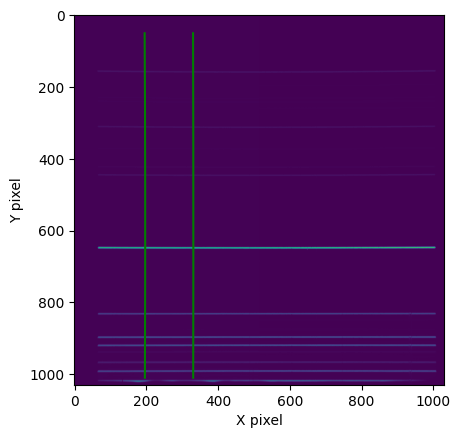

In [12]:
plt.figure()
plt.imshow(arc)
plt.plot(trace1[nframes//2],rows,color='g')
plt.plot(trace2[nframes//2],rows,color='g')
plt.ylabel('Y pixel')
plt.xlabel('X pixel')
plt.show()

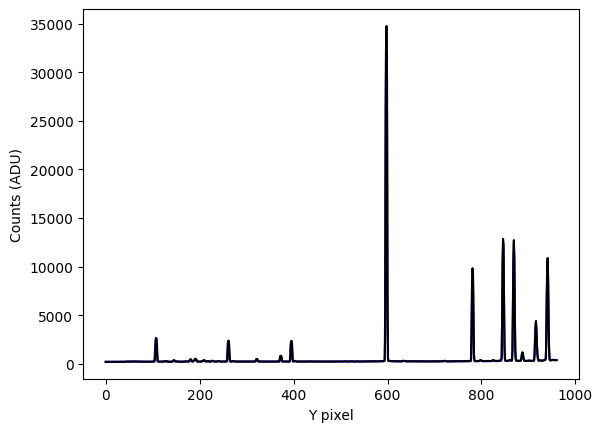

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [13]:
plt.figure()
plt.plot(slice_arc_1,color='b')
plt.plot(slice_arc_2, color='k')
plt.xlabel('Y pixel')
plt.ylabel('Counts (ADU)')
plt.show()
spectrum_1 = slice_arc_1
spectrum_2 = slice_arc_2
#spectrum_1 = np.median(arc.T, axis=0)

print(type(spectrum_2),type(spectrum_1))
#print(np.mean(abs(spectrum_1-spectrum_2)))

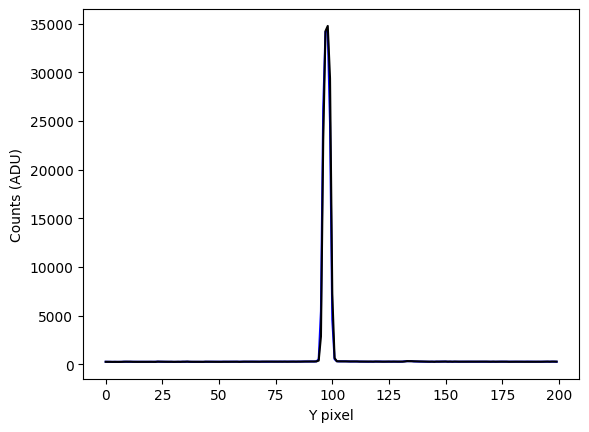

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [16]:
plt.figure()
plt.plot(slice_arc_1[500:700],color='b')
plt.plot(slice_arc_2[500:700], color='k')
plt.xlabel('Y pixel')
plt.ylabel('Counts (ADU)')
plt.show()
spectrum_1 = slice_arc_1
spectrum_2 = slice_arc_2
#spectrum_1 = np.median(arc.T, axis=0)

print(type(spectrum_2),type(spectrum_1))
#print(np.mean(abs(spectrum_1-spectrum_2)))

[Fri, 09 May 2025 16:09:00] INFO [calibrator.py:930] num_pix is set to 961.
[Fri, 09 May 2025 16:09:00] INFO [calibrator.py:942] pixel_list is set to None.
[Fri, 09 May 2025 16:09:00] INFO [calibrator.py:971] Plotting with matplotlib.


[107 190 261 321 395 598 781 846 887 916 941]
11


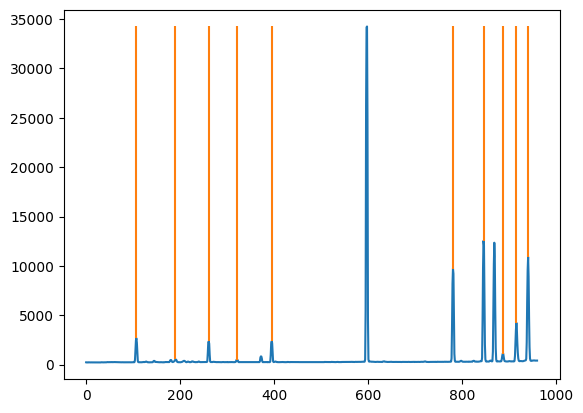

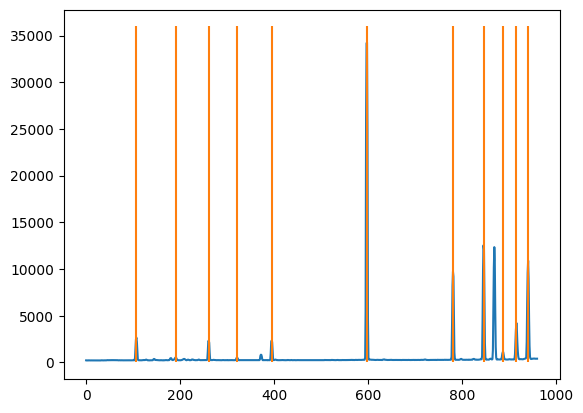

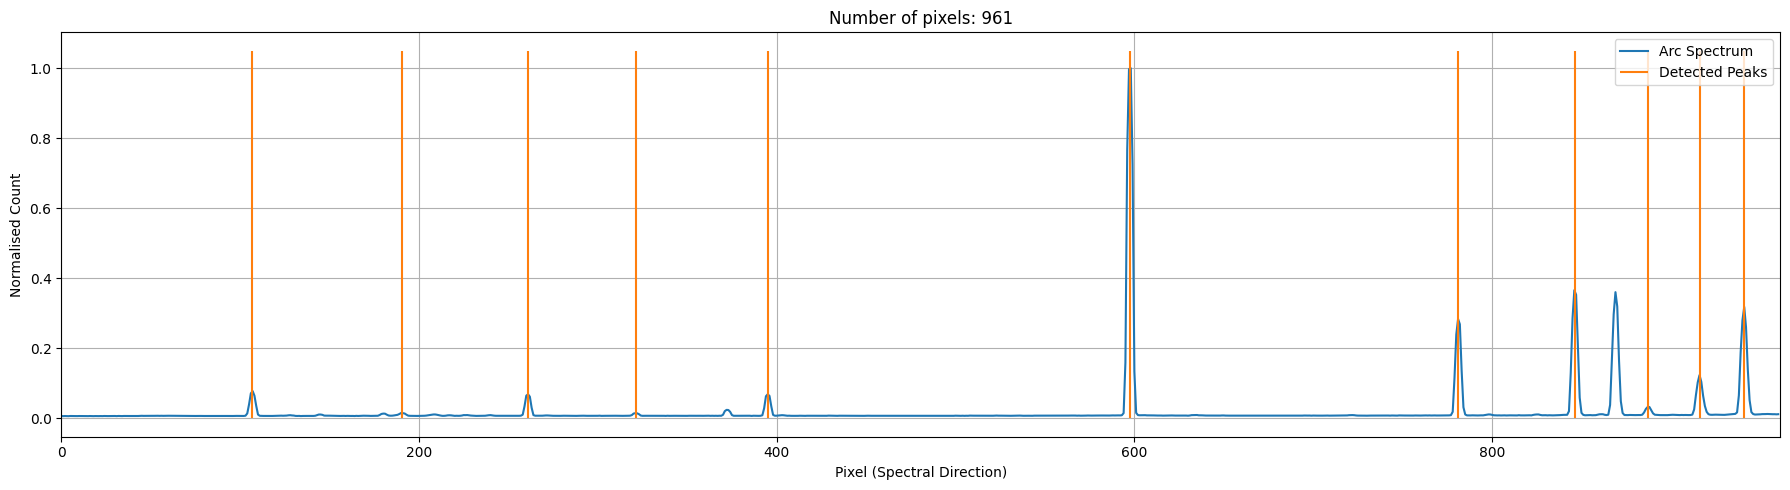

[Fri, 09 May 2025 16:09:00] WARNING [calibrator.py:1299] Using add_atlas is now deprecated. Please use the new Atlas class.


  0%|          | 0/200 [00:00<?, ?it/s]

[Fri, 09 May 2025 16:09:00] INFO [calibrator.py:750] Found: 4
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:805] Peak at: 4164.115375609567 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:809] - matched to 4164.115375609567 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:805] Peak at: 6043.130406312224 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:809] - matched to 6043.130406312224 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:805] Peak at: 7634.990435084479 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:809] - matched to 7634.990435084479 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:805] Peak at: 7890.955526517159 A
[Fri, 09 May 2025 16:09:00] INFO [plotting.py:809] - matched to 7890.955526517159 A


RMS: 1.0308281524655618
Stdev error: 0.4609252733905407 A
Peaks utilisation rate: 36.36363636363637%


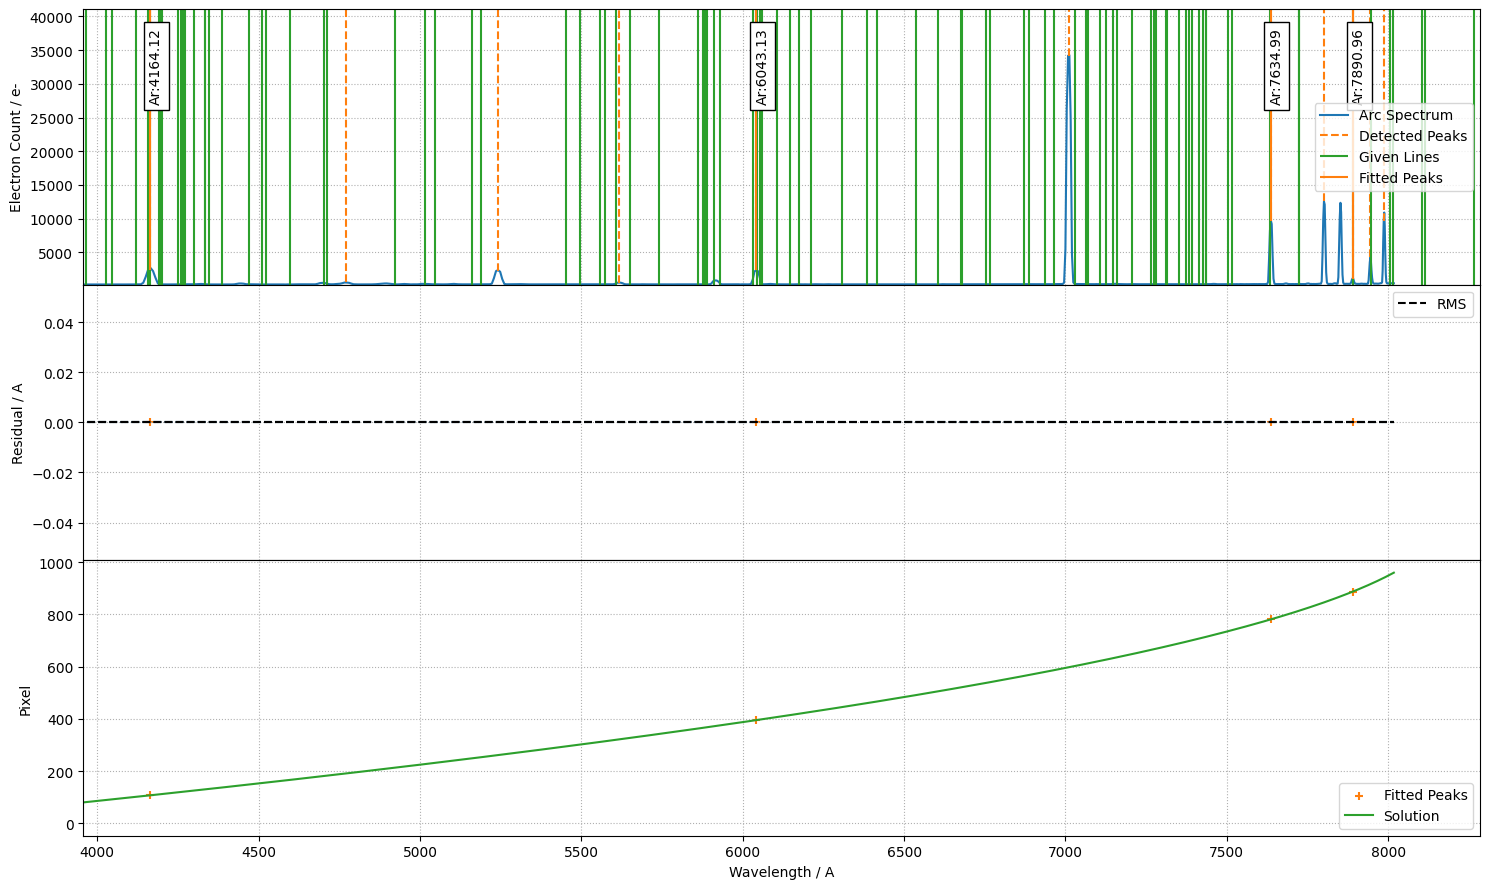

[ 3.31823267e+03  8.29460695e+00 -3.54133657e-03]
[0. 0. 0.]


In [17]:
wvl1 = rascal_find_wvl_solution(spectrum_1, 3000, 9000) # 3000 -> 9000 to match then spectrum (check the spectrum in the pdf in folder)

In [94]:
wvl1, wvl2

(array([3154.02730575, 3161.65658263, 3169.28225409, 3176.90432011,
        3184.5227807 , 3192.13763586, 3199.74888559, 3207.35652989,
        3214.96056876, 3222.5610022 , 3230.1578302 , 3237.75105277,
        3245.34066992, 3252.92668163, 3260.50908791, 3268.08788876,
        3275.66308418, 3283.23467417, 3290.80265872, 3298.36703785,
        3305.92781154, 3313.48497981, 3321.03854264, 3328.58850004,
        3336.13485201, 3343.67759855, 3351.21673966, 3358.75227533,
        3366.28420558, 3373.81253039, 3381.33724978, 3388.85836373,
        3396.37587225, 3403.88977534, 3411.400073  , 3418.90676523,
        3426.40985202, 3433.90933339, 3441.40520932, 3448.89747983,
        3456.3861449 , 3463.87120454, 3471.35265875, 3478.83050753,
        3486.30475088, 3493.7753888 , 3501.24242128, 3508.70584834,
        3516.16566996, 3523.62188615, 3531.07449691, 3538.52350224,
        3545.96890214, 3553.41069661, 3560.84888565, 3568.28346925,
        3575.71444743, 3583.14182017, 3590.56558

In [95]:
print(wvl2[0])
wvl1[0]
len(wvl1)

3189.449406262463


961

In [96]:
pickle.dump(wvl1,open(parent_direc+'/pickled_objects/arc_solution_trace1_rascal.pickle','wb'))
pickle.dump(wvl2,open(parent_direc+'/pickled_objects/arc_solution_trace2_rascal.pickle','wb'))